# MNIST

In [1]:
import datetime, os
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras import layers
from keras import activations
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.utils import plot_model

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# from keras_tqdm import TQDMNotebookCallback
# keras-tqdm does not work at 2024. Because keras_tqdm doesn't catch up the change of package structure of the TensorFlow 2.2.

# Parameters
NB_EPOCH = 50
BATCH_SIZE = 128
VERBOSE = 1
NB_CLASSES = 10
# OPTIMIZER = SGD()
# OPTIMIZER = RMSprop()
OPTIMIZER = Adam()
N_HIDDEN = 128
VALIDATION_SPLIT = 0.2
DROPOUT = 0.3

MODEL_LABEL = 'mnist-5-adam'

# random seed for reproducibility
np.random.seed(1671)

2024-04-15 14:58:32.221225: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 14:58:32.246426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 14:58:32.246441: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 14:58:32.246453: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 14:58:32.252413: I tensorflow/core/platform/cpu_feature_g

## 手書きの数字の画像を読み込む
- 28x28 の白黒画像
- 輝度は 0～255

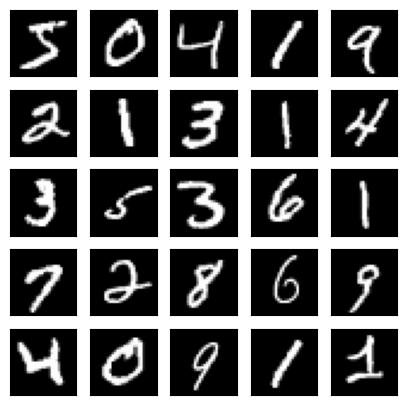

In [2]:

# Load MNIST dataset from Keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()

W = 5
H = 5
fig = plt.figure(figsize=(H, W))
for i in range(W*H):
    ax = fig.add_subplot(H, W, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i].reshape((28, 28)), cmap='gray')

plt.show()

## データの整形
- 28x28 の２次元データを 784 の １次元データに変換
- 画素を 0~255 ではなく 0～1 にする
- 画像に対応する数値ラベルは one-hot 形式にする
```python
 1 = [1,0,0,0,0,0,0,0,0,0]
 2 = [0,1,0,0,0,0,0,0,0,0]
 3 = [0,0,1,0,0,0,0,0,0,0]
 4 = [0,0,0,1,0,0,0,0,0,0]
 5 = [0,0,0,0,1,0,0,0,0,0]
 6 = [0,0,0,0,0,1,0,0,0,0]
 7 = [0,0,0,0,0,0,1,0,0,0]
 8 = [0,0,0,0,0,0,0,1,0,0]
 9 = [0,0,0,0,0,0,0,0,1,0]
 0 = [0,0,0,0,0,0,0,0,0,1]
```
- → 予測は、確率分布になる。下の場合は 5 の確率が 80%
```python
 y = [0.01, 0.02, 0.00, 0.00, 0.80, 0.00, 0.10, 0.01, 0.04, 0.01]
```

In [3]:
# ※ 2次元データの1次元化は Keras の Flatten() レイヤでやる。もっと変なフラット化をしたいときには、前処理で独自に実施する
# X_train is 60000 rows of 28x28 values --> reshaped in 60000 x 784
# RESHAPED = 28 * 28
# X_train = X_train.reshape(60000, RESHAPED)
# X_test = X_test.reshape(10000, RESHAPED)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalize
X_train /= 255.0
X_test /= 255.0

# Convert class vectors to binary class matrices
Y_train = to_categorical(y_train, NB_CLASSES)
Y_test = to_categorical(y_test, NB_CLASSES)

print('X_train' , X_train.shape)
print('X_test ' , X_test.shape)
print('Y_train' , Y_train.shape)
print('Y_test ' , Y_test.shape)

print('Y_train[0]', Y_train[0]) # 5 の確率 100%・ほかの確率 0%
print('Y_train[1]', Y_train[1]) # 0 の確率 100%・ほかの確率 0%
print('Y_train[2]', Y_train[2]) # 4 の確率 100%・ほかの確率 0%
print('Y_train[3]', Y_train[3]) # 1 の確率 100%・ほかの確率 0%
print('Y_train[4]', Y_train[4]) # 9 の確率 100%・ほかの確率 0%

X_train (60000, 28, 28)
X_test  (10000, 28, 28)
Y_train (60000, 10)
Y_test  (10000, 10)
Y_train[0] [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Y_train[1] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Y_train[2] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
Y_train[3] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Y_train[4] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


## ネットワークを作る
- 入力は 28x28の画像
- Flattenで1次元化する 
- 出力は 10 (=NB_CLASS) クラス
- 出力は Softmax (K次元の確率分布にする。各要素 0～1で、合計1)
- これに中間層を付け加える。中間層は 入力768→128→RELU→64→RELU→32→RELU→10→SOFTMAX→出力

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 activation_1 (Activation)   (None, 128)               0         
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

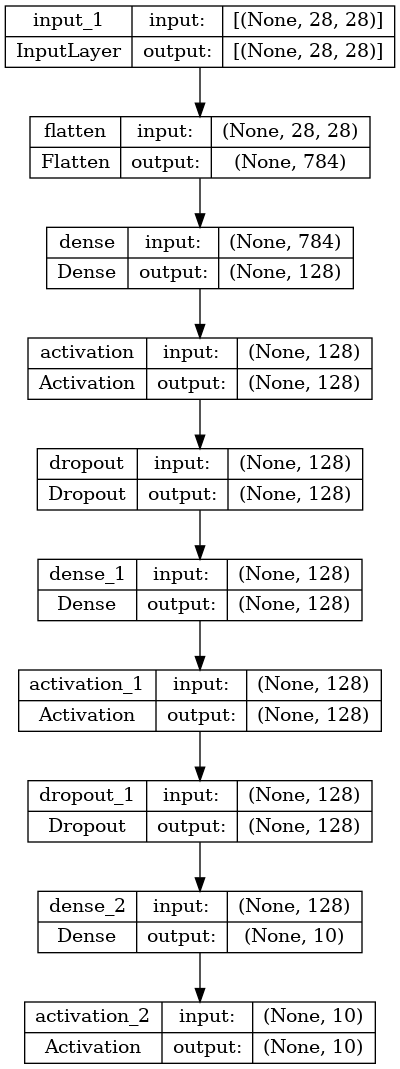

In [4]:
model = Sequential()
model.add(layers.Input(shape = (28, 28)))
model.add(layers.Flatten())
model.add(layers.Dense(N_HIDDEN))
model.add(layers.Activation(activations.relu))
model.add(layers.Dropout(DROPOUT))
model.add(layers.Dense(N_HIDDEN))
model.add(layers.Activation(activations.relu))
model.add(layers.Dropout(DROPOUT))
model.add(layers.Dense(NB_CLASSES))
model.add(layers.Activation(activations.softmax))
model.summary()

plot_model(model, show_shapes=True, to_file=(MODEL_LABEL + '_model.png'))

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

logdir = os.path.join("logs", MODEL_LABEL + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

history = model.fit(X_train, Y_train
          , batch_size=BATCH_SIZE
          , epochs=NB_EPOCH
          , verbose=VERBOSE
          , validation_split=VALIDATION_SPLIT
          , callbacks=[tensorboard_callback])

score = model.evaluate(X_test, Y_test, verbose=VERBOSE)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Epoch 1/50


2024-04-15 14:58:39.201375: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc250be5370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-15 14:58:39.201414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T550 Laptop GPU, Compute Capability 7.5
2024-04-15 14:58:39.205256: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-15 14:58:39.372226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-15 14:58:39.455221: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 [==============================] - 6s 9ms/step - loss: 0.5099 - accuracy: 0.8436 - val_loss: 0.1817 - val_accuracy: 0.9472
Epoch 2/50
375/375 [==============================] - 3s 8ms/step - loss: 0.2288 - accuracy: 0.9325 - val_loss: 0.1353 - val_accuracy: 0.9585
Epoch 3/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1779 - accuracy: 0.9460 - val_loss: 0.1178 - val_accuracy: 0.9646
Epoch 4/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1514 - accuracy: 0.9548 - val_loss: 0.1137 - val_accuracy: 0.9660
Epoch 5/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1307 - accuracy: 0.9603 - val_loss: 0.0915 - val_accuracy: 0.9709
Epoch 6/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1149 - accuracy: 0.9645 - val_loss: 0.0973 - val_accuracy: 0.9725
Epoch 7/50
375/375 [==============================] - 3s 8ms/step - loss: 0.1072 - accuracy: 0.9670 - val_loss: 0.0848 - val_accuracy: 0.9742
Epoch 8/50
375/37

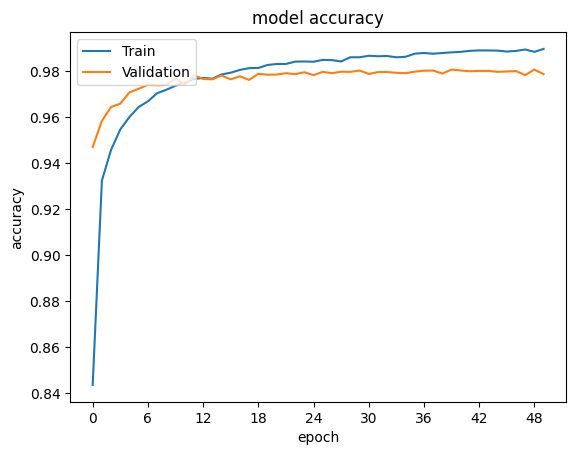

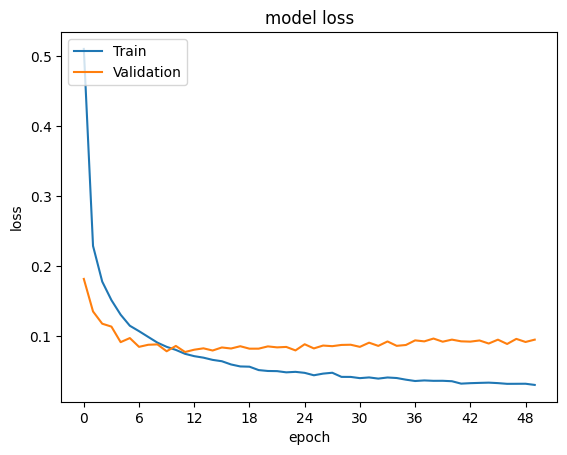

In [6]:
# summarize history for accuracy

fig, ax = plt.subplots()
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
fig, ax = plt.subplots()
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
# %load_ext tensorboard
# %tensorboard --logdir logs